In [334]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
from datetime import datetime
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')

In [335]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [336]:
# Segments id -> name mapping
seg_lst = config['segments']
# seg_lst

In [337]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [338]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [339]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle


In [340]:
pcloud = pd.DataFrame(scan[:, :3], columns=['x', 'y', 'z'])
pcloud = pyntcloud.PyntCloud(pcloud)
pcloud.plot(use_as_color='seg_id', cmap="cool", backend="pythreejs")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.14305366575717926, 59.59479224681854, 3.6…

In [166]:
# pcloud.plot(use_as_color='camera', cmap="cool")

In [294]:
# is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
# test_cloud.points['is_parking'] = pd.Series(is_parking)

In [167]:
# test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

In [168]:
# is_parking = test_cloud.points['is_parking'] != 1
# test_cloud.apply_filter(is_parking)

In [169]:
# test_cloud.plot()

In [90]:
# n_voxels = 45
# voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [170]:
# %time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

In [171]:
# test_cloud.plot(use_as_color=cluster_id, cmap="cool")

In [10]:
from pipeline import common
common = imp.reload(common)

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [12]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster._dbscan:

class DBSCAN(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
 |  
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, default=0.5
 |      The maximum distance between two samples for one to be considered
 |      as in the neighborhood of the other. This is not a maximum bound
 |      on the distances of points within a cluster. This is the most
 |      important DBSCAN parameter to choose appropriately for your data set
 |      and distance function.
 |  
 |  min_sample

In [225]:
def pipeline_optimized(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    
    n = 1000
    
    # ROI filtering
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)
    roi_time = (datetime.now() - start_time).total_seconds()
    

    # Obstacles filtering
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pyntcloud.PyntCloud(pcloud)
    obstacle_time = (datetime.now() - start_time).total_seconds()
    
    if len(pcloud.points) > 200:
        
        # Getting voxel grid
        start_time = datetime.now()
        voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=params['x_voxels'], 
                                                         n_y=params['y_voxels'],
                                                         n_z=params['z_voxels'],
                                                         regular_bounding_box=False)
        voxel_time = (datetime.now() - start_time).total_seconds()

        # Сlustering obstacles
        start_time = datetime.now()
#         cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
        clusterer = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], 
                           n_jobs=-1, algorithm='auto', leaf_size=params['leaf_size'])
        clusterer.fit(pcloud.points[['x', 'y', 'z']])
        pcloud.points['cluster_id'] = clusterer.labels_
        cluster_id = 'cluster_id'
        cluster_time = (datetime.now() - start_time).total_seconds()
        
        # Getting cluster min max points fot bounding boxes
        start_time = datetime.now()
        pcloud.points['norm'] = np.sqrt(np.square(pcloud.points[['x', 'y', 'z']]).sum(axis=1))
        clusters = pd.DataFrame.from_dict({key: [] for key in pcloud.points.columns})
        for _id in pcloud.points[cluster_id].unique():
            if _id == -1 or len(pcloud.points[pcloud.points[cluster_id] == _id]) < 10:
                continue
            tcluster = common.outlier_filter(pcloud.points[pcloud.points[cluster_id] == _id],
                                             verbose=False)
            clusters = clusters.append(tcluster)
        
        clusters = clusters.groupby([cluster_id]).agg({ 'x': ['min', 'max'],
                                                        'y': ['min', 'max'],
                                                        'z': ['min', 'max'] }).values
        
        cluster_data = pcloud.points[['x', 'y', 'z', cluster_id]]
        cluster_data = cluster_data.rename(columns ={cluster_id: 'cluster_id'})
        min_max_time = (datetime.now() - start_time).total_seconds()
    else:
        clusters, cluster_data = np.empty((0, 0)), np.empty((0, 0))
        voxel_time, cluster_time, min_max_time = 0, 0, 0
        
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.5f}s'.format(roi_time))
        print('\n - Filtering obstacles: {:.5f}s'.format(obstacle_time))
        print('\n - Voxel grid: {:.5f}s'.format(voxel_time))
        print('\n - Clustering: {:.5f}s'.format(cluster_time))
        print('\n - Min-max cluster points: {:.5f}s \n'.format(min_max_time))
#         print('\n - Score: {:.5f} \n'.format(score))
        
    if exec_time:
        return clusters, cluster_data, {'roi_time': roi_time,
                                        'filter_obstacle_time': obstacle_time,
                                        'voxel_grid_time': voxel_time,
                                        'clustering_time': cluster_time,
                                        'outlier_filter_bbox_time': min_max_time}
    else:
        return clusters, cluster_data

## Pipeline implementation

In [226]:
%time 
num='075'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 17.9 µs


{
   "eps": 0.6,
   "leaf_size": 200,
   "min_samples": 100,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 26,
   "y_voxels": 30,
   "z_voxels": 6
} Time and n clusters (0.718542, 6, 0.6822343580023242)

In [227]:
%%time
params = {'x_voxels': 26, 'y_voxels': 30, 'z_voxels': 6, 
          'roi_x_min': 0, 'roi_x_max': 45,
          'roi_y_min': -14, 'roi_y_max': 14,
          'roi_z_min': -2, 'roi_z_max': 1,
          'eps': 0.7, 'min_samples': 6, 'leaf_size': 120}         
clusters, cluster_data, time_exec= pipeline_optimized(scan, label, obstacle_lst, verbose=True, 
                                    exec_time=True, **params)

Execution time:

 - ROI filtering: 0.03205s

 - Filtering obstacles: 0.11397s

 - Voxel grid: 0.00280s

 - Clustering: 0.91876s

 - Min-max cluster points: 0.27029s 

CPU times: user 2.64 s, sys: 60.5 ms, total: 2.7 s
Wall time: 1.34 s


In [ ]:
min_poitns = [cluster_data[cluster_data.index == indx][['x', 'y', 'z']].values 
              for indx in list(cluster_data[['x', 'y', 'z']].idxmin())]
max_points = [cluster_data[cluster_data.index == indx][['x', 'y', 'z']].values 
              for indx in list(cluster_data[['x', 'y', 'z']].idxmax())]
vertices_lst = min_poitns + max_points

array = vertices_lst[0]
for x in vertices_lst[1:]:
    array = np.concatenate((array, x), axis=1)

In [325]:
array.shape

(1, 18)

In [326]:
clusters_rotated = np.empty((0,18))

In [328]:
array = np.concatenate((clusters_rotated, array), axis=0)

In [329]:
array

array([[ 1.73162967e-02, -3.45766473e+00, -5.80362141e-01,
         2.25728016e+01, -1.21158047e+01,  3.25436797e-03,
         6.51805758e-01,  8.15909481e+00, -1.84420311e+00,
         4.08433151e+01, -3.97095132e+00, -1.18114762e-01,
         9.49204350e+00,  1.07075558e+01, -1.29694593e+00,
         3.85992203e+01, -4.28684473e+00,  3.27835798e-01]])

In [307]:
str(vertices_lst)

'[(0.017316296696662903, -3.457664728164673, -0.5803621411323547), (22.57280158996582, -12.115804672241211, 0.003254367969930172), (0.6518057584762573, 8.15909481048584, -1.8442031145095825), (40.84331512451172, -3.9709513187408447, -0.11811476200819016), (9.492043495178223, 10.707555770874023, -1.2969459295272827), (38.599220275878906, -4.286844730377197, 0.3278357982635498)]'

In [256]:
cluster_data[cluster_data.index == 73504]

,x,y,z,cluster_id
73504,0.017316,-3.457665,-0.580362,6


In [255]:
cluster_data.min()

x              0.017316
y            -12.115805
z             -1.844203
cluster_id    -1.000000
dtype: float64

In [228]:
silhouette_score(cluster_data[['x', 'y', 'z']], cluster_data['cluster_id'])

0.7483929295686031

In [229]:
clusters.shape

(15, 6)

In [154]:
sum(time_exec.values())

1.244956

In [155]:
%%timeit
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, verbose=False, **params)

1.17 s ± 73.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%time box_coord_list = common.get_bounding_boxes(pd.DataFrame(clusters))
print('It is {} clusters'.format(len(box_coord_list)))

CPU times: user 2.62 ms, sys: 2.06 ms, total: 4.68 ms
Wall time: 4.22 ms
It is 6 clusters


In [43]:
# %time box_coord_list = common.get_optimal_bboxes(clusters, cluster_data)
# print(len(box_coord_list))

In [224]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(4.196771361937243, 10.999629521900943, -0.23…

In [45]:
# cluster_data

In [40]:
from scripts import draw
draw = imp.reload(draw)

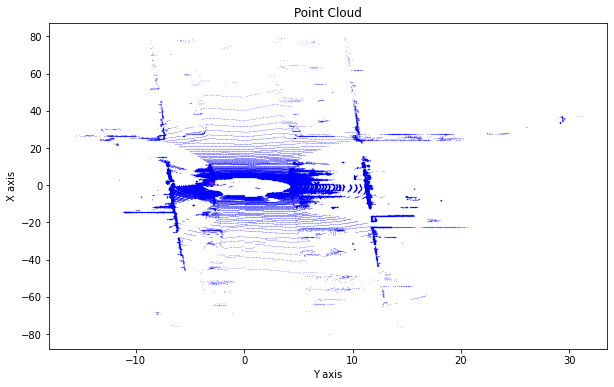

In [45]:
%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [1056]:
pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
%time cloud = common.obstacle_filter(pcloud, obstacle_lst)

Filter required segments
Point size before: 119053 and after filtering: 19133
CPU times: user 250 ms, sys: 64 µs, total: 250 ms
Wall time: 251 ms


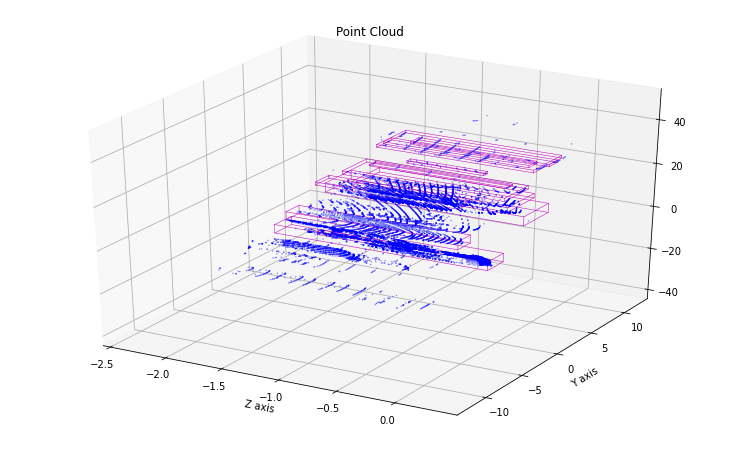

In [1057]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [2,1,0]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

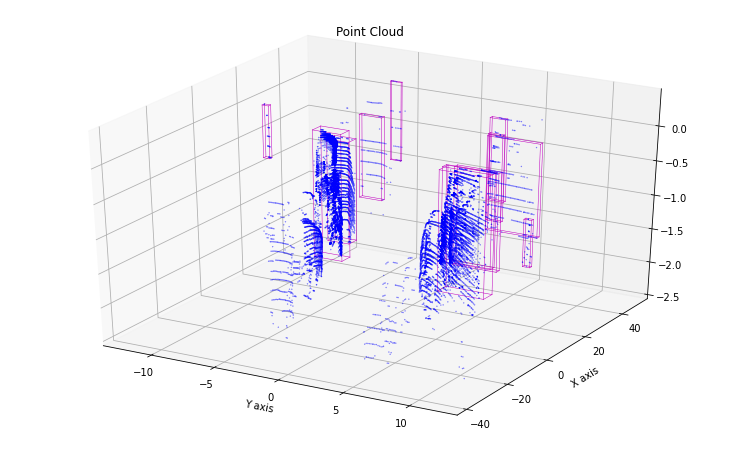

In [1058]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [1,0,2]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Grid Search Optimization

In [1485]:
help(test.grid_search_optimization)

Help on function grid_search_optimization in module scripts.test:

grid_search_optimization(scan, label, obstacle_lst, pipeline, params, verbose=True)
    Grid Search of hyperparametrs for optimization of executional time of pipeline
    
    scan: numpy.array,
    An N X 3 array of point cloud from LIDAR
    
    label: numpy.array,
    A list of segmentation labels respectively
    
    obstacle_lst: list,
    A list of obstacles id
    
    pipeline: function,
    An obstacle-detection pipeline function
    
    params: dict,
    A dictionary of params range that is reqired to search
    
    verbose: bool, optional, defualt True
    Whether or not print info during execution.



In [93]:
from scripts import test
test = imp.reload(test)
range_params  = { 'x_voxels': [26], 'y_voxels': [30], 
                  'z_voxels': [6], 
                  'roi_x_min': [0], 'roi_x_max': [45],
                  'roi_y_min': [-14], 'roi_y_max': [14],
                  'roi_z_min': [-2], 'roi_z_max': [1],
                  'eps': [0.07, 0.1, 0.2, 0.4, 0.6, 0.7, 1, 1.5], 'min_samples': [5, 10, 20, 50, 70, 100], 
                  'leaf_size': [10, 20, 50, 100, 200]}  
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline_optimized, 
                                              range_params, score=True, verbose=False)

In [113]:
time_ex_lst = {k: v  for k, v in time_exec_lst.items() if v[-1] > 0.55} 
sorted_exec_dct = {k: v for k, v in sorted(time_ex_lst.items(), key=lambda item: item[1][0], reverse=False)}

In [114]:
n = 10
for i, key in enumerate(sorted_exec_dct):
    if i == n:
        break
    print(key,'Time and n clusters', sorted_exec_dct[key])

{
   "eps": 0.4,
   "leaf_size": 50,
   "min_samples": 70,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 26,
   "y_voxels": 30,
   "z_voxels": 6
} Time and n clusters (0.688884, 7, 0.5982229836037758)
{
   "eps": 0.6,
   "leaf_size": 200,
   "min_samples": 100,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 26,
   "y_voxels": 30,
   "z_voxels": 6
} Time and n clusters (0.718542, 6, 0.6822343580023242)
{
   "eps": 0.4,
   "leaf_size": 10,
   "min_samples": 100,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 26,
   "y_voxels": 30,
   "z_voxels": 6
} Time and n clusters (0.867413, 6, 0.5723040344130542)
{
   "eps": 0.7,
   "leaf_size": 50,
   "min_samples": 100,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_m

## Getting bounding boxes and grep statistics for sequence 

In [259]:
import glob
seq = '00'
scan_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [331]:
from scripts import test
test = imp.reload(test)

In [332]:
# help(test.get_bbox_and_stat)

In [333]:
%%time
# n_scan = -1
write_path = '../dataset/sequences/' + seq + '/clusters/'
# write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                        pipeline_optimized, write_path=write_path, 
                                                        write_rotated=True, detailed=True, **params)


CPU times: user 3min 25s, sys: 7.04 s, total: 3min 32s
Wall time: 3min 11s


In [310]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

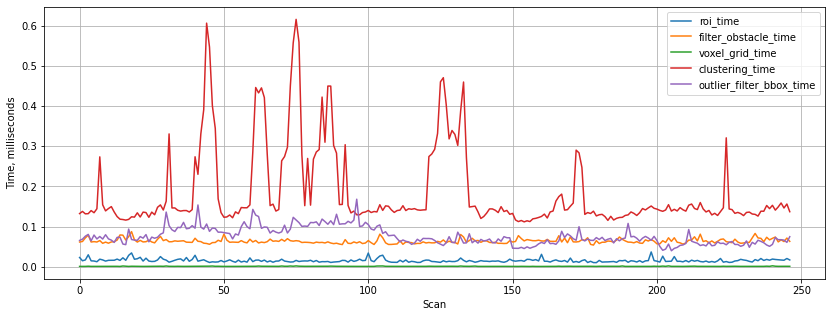

In [311]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, milliseconds')
plt.grid()
plt.show()

In [274]:
time_stat = list(exec_time_dct.values())
print('Min process time {} s'.format(min(time_stat)))
print('Mean process time {} s'.format(np.mean(time_stat)))
print('Max process time {} s'.format(max(time_stat)))

Min process time 0.223233 s
Mean process time 0.32062320915032677 s
Max process time 0.81408 s


In [272]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

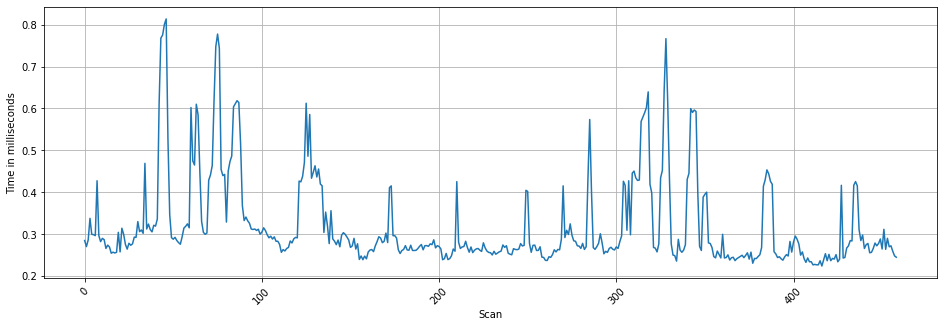

In [275]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in milliseconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Grep statistics of execution time

In [442]:
exec_lst = []
n_epoch = 3
for i in range(n_epoch):
    _, exec_time_dct = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                              pipeline_optimized, write_path=None,
                                                                  x_voxels=25,
                                                                  y_voxels=20,
                                                                  z_voxels=5)
    exec_lst.append(exec_time_dct)

In [452]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append([tdelta.microseconds for tdelta in epoch.values()])
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [454]:
several_exec_time_lst[:3]

[(387403, 382174, 361611), (418736, 408954, 395278), (383912, 373594, 357415)]

In [457]:
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

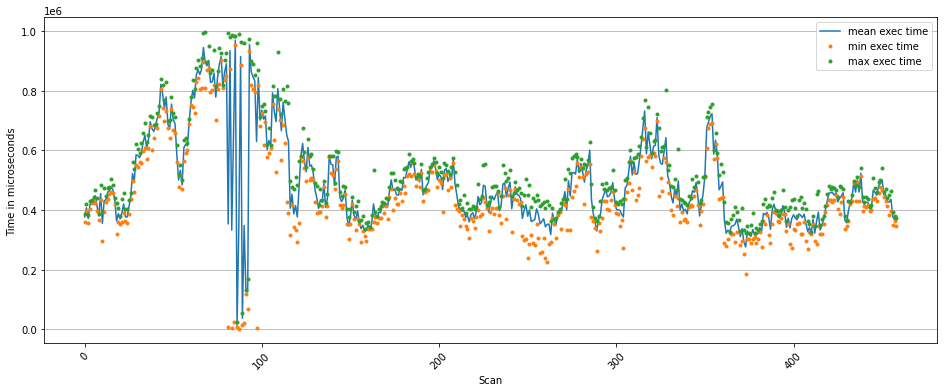

In [464]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.xlabel('Scan')
plt.ylabel('Time in microseconds')
plt.legend()
plt.show()